### LangGraph ReAct Agent -03 — Math Tools + Web Search + Stock Price

In [27]:
# =============================================================================
# This script builds a ReAct (Reasoning + Acting) agent step by step:
#   1. Define custom math tools  (add, multiply, divide)
#   2. Add a web search tool     (DuckDuckGo)
#   3. Add a stock price tool    (Yahoo Finance)
#   4. Wire everything into a LangGraph agent loop
#
# Pattern recap from Part 1:
#   START → LLM → (tool call?) → tools → LLM → ... → END
# ============================================================================= 

In [28]:
# ── 0. Imports & LLM Setup ───────────────────────────────────────────────────
from dotenv import load_dotenv
load_dotenv()

import yfinance as yf
from langchain_groq import ChatGroq
from langchain.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
import warnings
# FIX 3 — suppress the "duckduckgo_search renamed to ddgs" deprecation spam.
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display


In [29]:

# Initialize the language model
# This is the "brain" that will answer questions
# temperature=0 makes the model deterministic — better for tool-calling agents
# because we want consistent, logical decisions rather than creative variation.

model = ChatGroq(
    model="openai/gpt-oss-120b",  # Use actual Groq model
    #api_key="your-groq-api-key-here",  # Get from https://console.groq.com
    temperature=0
)

llm = model  # Alias for clarity in the agent context

#### PART 1 — Define Custom Tools

In [30]:
# Each function decorated with @tool becomes a LangChain tool.
# The docstring is what the LLM reads to decide WHEN and HOW to call the tool,
# so write it like instructions for a colleague, not a Python comment.

@tool
def add(a: int, b: int) -> int:
    """Add two integers and return the result."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two integers and return the result."""
    return a * b

@tool
def divide(a: int, b: int) -> float:
    """
    Divide two integers. Raises an error if the denominator is zero.

    Args:
        a: numerator
        b: denominator (must not be 0)
    """
    if b == 0:
        raise ValueError("Cannot divide by zero.")
    return a / b

#### PART 2 — Add Web Search & Stock Price Tools

In [31]:

# DuckDuckGoSearchRun is a pre-built LangChain tool — no API key needed.
# The LLM will call it whenever it needs real-time information from the web.
web_search = DuckDuckGoSearchRun()

In [32]:
@tool
def get_stock_price(ticker: str) -> str:
    """
    Fetch the most recent closing price of a stock from Yahoo Finance.

    Args:
        ticker: Stock symbol, e.g. 'AAPL', 'TSLA', 'ADANIGREEN.NS'

    Returns:
        A human-readable string with the closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get("previousClose")
        if price is None:
            return f"Could not fetch a price for ticker '{ticker}'. Try a different symbol."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"Error fetching stock data: {e}"


In [33]:
# Quick sanity checks (comment these out in production)
print(get_stock_price.invoke("AAPL"))
print(get_stock_price.invoke("TSLA"))
print(web_search.invoke("latest iPhone 17 news"))


The last closing price of AAPL was $264.35.
The last closing price of TSLA was $411.22.


c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


1 day ago · Latest news headlines from India & around the world. Check out today’s news coverage live with videos & photos on … 14 hours ago · Top News Stories of the day, Latest News Headlines, News Specials, Breaking News and Latest India News, World current … NDTV.com provides latest news from India and around the world. Get breaking news alerts from India and follow today’s live news updates in … 22 hours ago · India News | Latest India News | Read latest and breaking news from India. Today's top India news headlines, news on … 1 day ago · Get Latest entertainment news from Bollywood, Hollywood and regional film industries.


#### PART 3 — Bind All Tools to the LLM

In [34]:
# Collect all tools in one list — this makes it easy to add/remove later.
tools = [add, multiply, divide, web_search, get_stock_price]

# bind_tools() teaches the LLM about every tool:
#   - what each tool is called
#   - what arguments it expects
#   - when to use it (based on the docstring)
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False) 

# How the LLM responds depends on the query:
#   "what is 2+2?"         → tool_calls: [add(a=2, b=2)]
#   "hi how are you?"      → content: "Hello! ..."  (no tool call)
#   "AAPL stock price?"    → tool_calls: [get_stock_price(ticker='AAPL')]


#### PART 4 — System Prompt

In [35]:
# A SystemMessage sets the overall behaviour of the assistant.
# It's prepended to every LLM call so the model always knows its role.

SYSTEM_PROMPT = SystemMessage(
    content=(
        "You are a helpful assistant. You have access to tools for: "
        "arithmetic (add, multiply, divide), web search, and stock prices. "
        "Always use the appropriate tool instead of guessing."
    )
)


In [36]:
def llm_node(state: MessagesState) -> dict:
    """
    LLM reasoning node.

    Prepends the system prompt to the conversation history, then calls
    the tool-aware LLM. The LLM either:
      (a) returns a final text answer  → graph routes to END
      (b) requests a tool call         → graph routes to the tools node
    """
    messages = [SYSTEM_PROMPT] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


#### PART 5 — Build the ReAct Graph

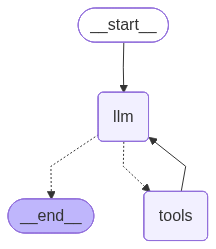

In [37]:
# ReAct loop:  llm_node ──(tool call?)──► tools ──► llm_node ──► ...──► END
#
# tools_condition is a pre-built LangGraph helper that replaces our custom
# router function from Part 1. It does exactly the same thing:
#   last message has .tool_calls  → return "tools"
#   last message has no tool call → return END

builder = StateGraph(MessagesState)

builder.add_node("llm", llm_node)              # reasoning step
builder.add_node("tools", ToolNode(tools))     # tool execution step

builder.add_edge(START, "llm")

# tools_condition automatically routes to "tools" or END
builder.add_conditional_edges("llm", tools_condition)

# After any tool runs, always return to the LLM to process the result
builder.add_edge("tools", "llm")

react_agent = builder.compile()

# Visualise the graph
display(Image(react_agent.get_graph().draw_mermaid_png()))


#### PART 6 — Run the Agent

In [38]:
def run(query: str) -> None:
    """Send a query to the agent and pretty-print the full message trace."""
    print(f"\n{'='*60}")
    print(f"Query: {query}")
    print('='*60)

    # FIX 1 — recursion_limit caps the agent loop at 10 steps.
    # Default is 25. Smaller models (DeepSeek distilled) can loop endlessly,
    # hitting the limit and raising GraphRecursionError without this guard.
    config = {"recursion_limit": 10}

    # FIX 2 — catch GraphRecursionError gracefully so one bad query
    # doesn't crash the whole notebook.
    try:
        result = react_agent.invoke(
            {"messages": [HumanMessage(content=query)]},
            config=config,
        )
        for message in result["messages"]:
            message.pretty_print()
    except Exception as e:
        if "GraphRecursionError" in type(e).__name__ or "recursion" in str(e).lower():
            print(f"⚠️  Agent looped too many times and was stopped. "
                  f"Try rephrasing the query or using a stronger model.")
        else:
            raise


In [41]:
# --- Test 1: Multi-step reasoning (search → multiply) ---
run("What is 2 times Narendra Modi's age?")
# Expected flow: search Modi's age → multiply result by 2 → final answer



Query: What is 2 times Narendra Modi's age?


c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package

⚠️  Agent looped too many times and was stopped. Try rephrasing the query or using a stronger model.


In [40]:
# --- Test 2: Multi-step (search → divide) ---
run("What is Elon Musk's net worth? Divide it by 2.")
# Expected flow: search net worth → divide → final answer


Query: What is Elon Musk's net worth? Divide it by 2.


c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package

⚠️  Agent looped too many times and was stopped. Try rephrasing the query or using a stronger model.


In [42]:
# --- Test 3: Pure math (no search needed) ---
run("What is the speed of light in m/s multiplied by 10?")
# Expected flow: LLM knows speed of light → multiply → final answer


Query: What is the speed of light in m/s multiplied by 10?
================================ Human Message =================================

What is the speed of light in m/s multiplied by 10?
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_8bec62e0-b90c-4416-83e8-02c4227b52e1)
 Call ID: fc_8bec62e0-b90c-4416-83e8-02c4227b52e1
  Args:
    a: 299792458
    b: 10
================================= Tool Message =================================
Name: multiply

2997924580
================================== Ai Message ==================================

The speed of light is \(299{,}792{,}458\) m/s, and multiplied by 10 it equals **2,997,924,580 m/s**.


In [43]:
# --- Test 4: Stock price + arithmetic ---
run("Add 1000 to the current stock price of Apple.")
# Expected flow: get_stock_price('AAPL') → add(price, 1000) → final answer


Query: Add 1000 to the current stock price of Apple.
================================ Human Message =================================

Add 1000 to the current stock price of Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (fc_c713da5b-7acb-41e8-bad8-327933f50bef)
 Call ID: fc_c713da5b-7acb-41e8-bad8-327933f50bef
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $264.35.
================================== Ai Message ==================================

The last closing price of Apple (AAPL) was **$264.35**. Adding $1,000 gives:

**$264.35 + $1,000 = $1,264.35**.


In [44]:
# --- Test 5: Stock price + web search together ---
run("Give me 2 times the current stock price of Apple and the latest Apple news.")
# Expected flow: get_stock_price + web_search → multiply → final answer


Query: Give me 2 times the current stock price of Apple and the latest Apple news.


c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\HP\anaconda3\envs\lcenv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package

⚠️  Agent looped too many times and was stopped. Try rephrasing the query or using a stronger model.
